# Setup

In [6]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension


import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
# Imports

%load_ext autoreload
import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BigBirdPegasusForConditionalGeneration, DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load Pegasus fine-tuned on Arxiv

model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")

model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")



In [ ]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [ ]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, ax, label, color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [ ]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/arxiv_pegasus/generated/orig.txt'
greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/arxiv_pegasus/generated/greedy.csv"

In [ ]:
NUM_SEQ=100
MAX_LEN = 256
MAX_SOURCE_LEN=2048
WIDTH=10

# Entropy of Human Data

In [ ]:
human_dataframe = pd.read_csv(orig_wp, sep='\t', names=['context', 'model_text'])
human_dataframe['model_text'] = human_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

In [ ]:
human_datapoint = human_dataframe.sample(1).iloc[0]
# print(human_datapoint.context)
print()
print(print_sample(human_datapoint.context, human_datapoint.model_text))


one of the key sources of transverse impedance in the lhc has been the secondary graphite collimators that sit close to the beam at all energies . 
 this limits the stable bunch intensity due to transverse coupled - bunch instabilities and transverse mode coupling instability . to counteract this , 
 new secondary collimators have been proposed for the phase ii upgrade of the lhc collimation system . 
 a number of designs based on different jaw materials and mechanical designs have been proposed . 
 a comparison of the beam coupling impedance of these different designs derived from simulations are presented , with reference to the existing phase i secondary collimator design .
None


## Compute Average entropy across sequences.

In [ ]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

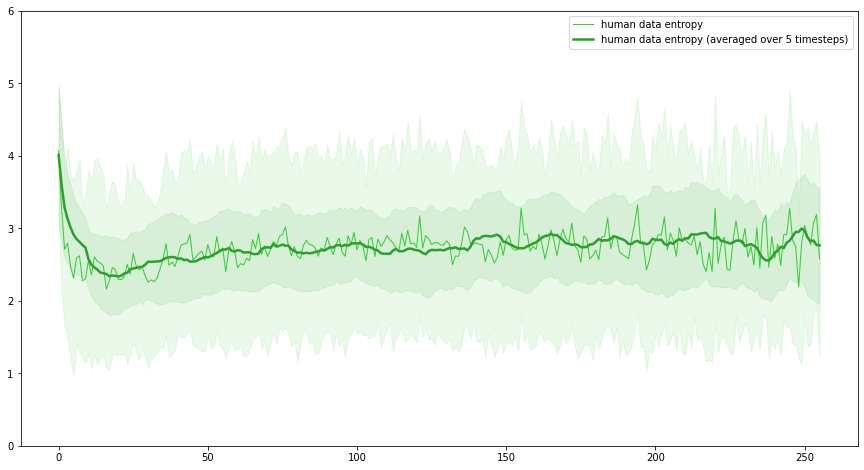

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='limegreen')
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', linewidth=2.5)

## Examples of generation

In [ ]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


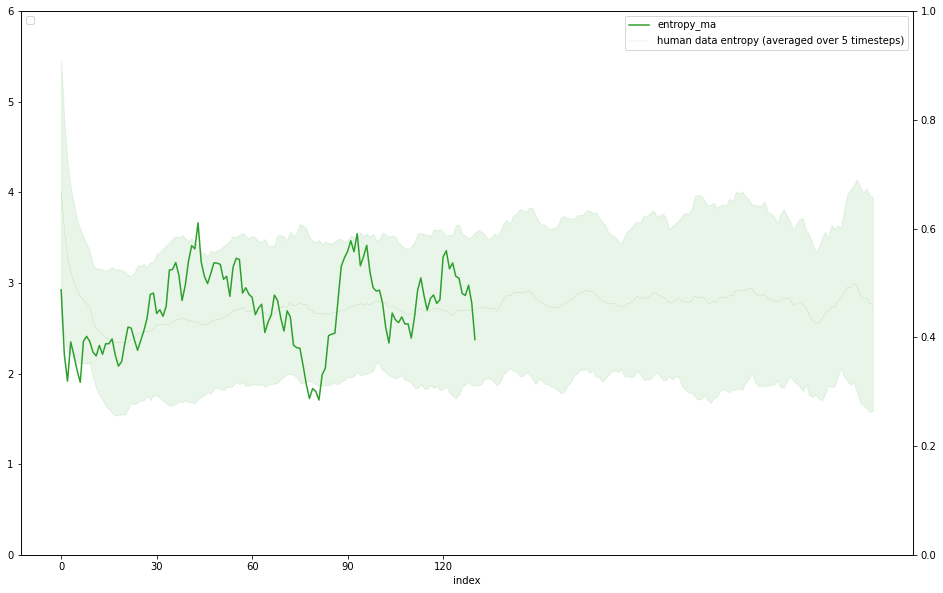

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
ax2 = ax.twinx()
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2.legend(loc=2)

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, color='tab:green')
ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

# Entropy of Model Data

In [ ]:
model_greedy_dataframe = pd.read_csv(greedy_generation, sep='\t', names=['context', 'model_text'])

## Examples of various amounts of 3-gram repetition.

In [ ]:
human_datapoint = human_dataframe.sample(1).iloc[0]
# print()
# print(print_sample(human_datapoint.context, human_datapoint.model_text))

human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

In [ ]:
print("Context:")
print_sample(human_datapoint.model_text, human_datapoint.context, repeat_type="context")


Context:
the large hadron collider ( lhc ) has been in operation since the end of 2009 and has collided protons at center of mass energies @xmath1  tev , 2.76  tev and 7  tev and lead nuclei at @xmath0  tev .<newline>one of the experiments at the lhc is alice which focuses on measuring heavy - ion collisions and minimum - bias pp  collisions .<newline>the main goal of the analysis is to study the quark - gluon plasma ( qgp ) which is postulated to be created in pb - pb interactions .<newline>one of the reasons to study pp  collisions is to provide a `` baseline '' for the heavy - ion measurements , so direct comparisons between the two collision types are especially interesting .    the qgp has been observed at lower energies at relativistic heavy - ion collider ( rhic )  @xcite and possibly also at the super proton synchrotron ( sps ) at cern .<newline>one of the defining properties of the system created in such collisions is its rapid evolution , which was found to be well described 

In [204]:

greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
# print("Context:")
# print_sample(human_datapoint.model_text, human_datapoint.context, )


print("Target:")
print_sample(human_datapoint.context, human_datapoint.model_text.replace("\n", "\\n"))
print()
print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "\\n"))
print()

Target:
we report on the results of femtoscopic analysis of pb - pb collisions at @xmath0  tev and pp  collisions at @xmath1 , @xmath2 and @xmath3  tev with identical pions and kaons . \n detailed femtoscopy studies in heavy - ion collisions at sps and rhic have shown that emission region sizes ( `` hbt radii '' ) decrease with increasing pair transverse momentum @xmath4 , which is understood as a manifestation of the collective behavior of matter . \n the trend was predicted to persist at the lhc . \n the data from pb - pb collisions confirm the existence of a flowing medium and provide strict constraints on the dynamical models . \n similar analysis is carried out for pp  collisions for pions and kaons and qualitative similarities to heavy - ion data are seen , especially in collisions producing large number of particles . \n the observed trends give insight into the soft particle production mechanism in pp  collisions . \n 3d radii were also found to universally scale with event mul

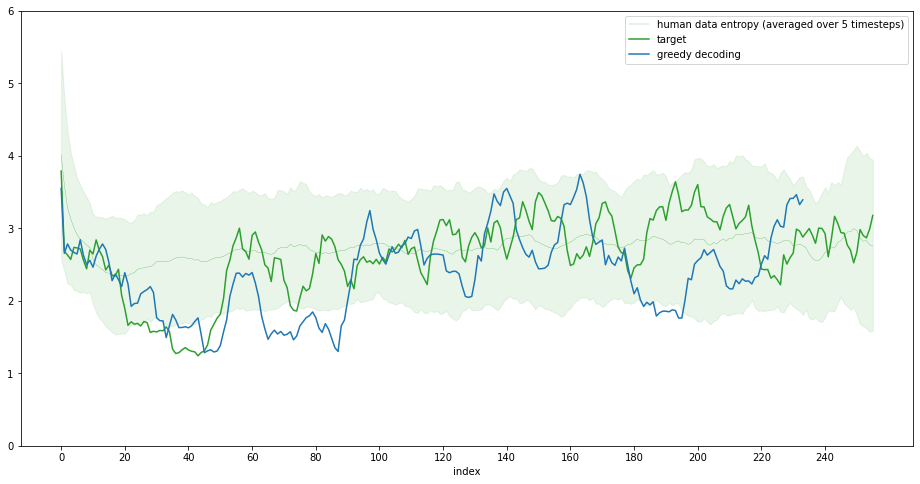

In [205]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

greedy_labeled_datapoint = process_datapoint(
    model=model, datapoint=greedy_sample, width=WIDTH, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

fig, ax = plt.subplots(figsize=(16, 8))
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.25)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='target', color='tab:green')
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='greedy decoding', color='tab:blue')
# lpdm.plot(x="index", y='dent', ylim=(-4,6), ax=ax)
ax.set_xticks(np.arange(len(lpdh['index']), step=20))

# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

## Compute Average entropy across timesteps.

### For all model generated data

In [142]:
# Greedy

model_greedy_dataframe = model_greedy_dataframe.dropna()
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy', width=WIDTH,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps (Model Data w/ Repetition)'}, xlabel='Timesteps', ylabel='Average Entropy'>

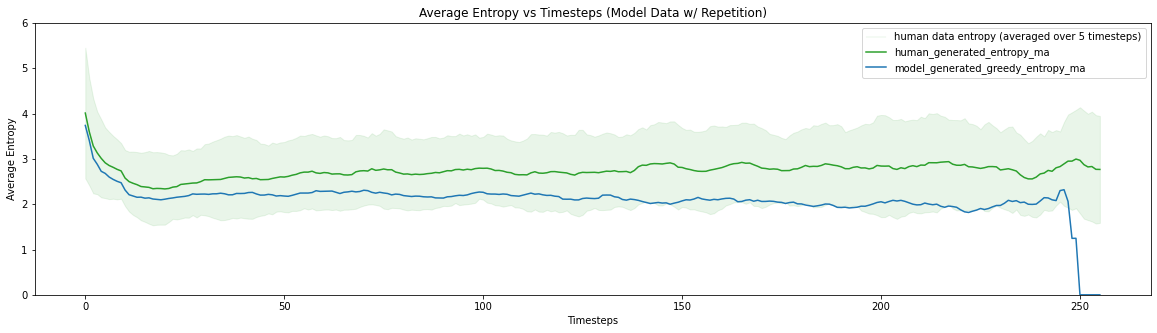

In [107]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps (Model Data w/ Repetition)', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Do errors cascade?

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")